# **Proyek Machine Learning**

Nama: Melanie Sayyidina Sabrina Refman

## **Import Dataset**

In [37]:
from google.colab import files

# Mengupload file kaggle
files.upload()

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"melanierefman","key":"ce0211165e67e656e93a08a36a7acd09"}'}

In [38]:
# Mengonfigurasi Kaggle API di lingkungan Colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [39]:
# Mengunduh dataset dari Kaggle menggunakan Kaggle API
!kaggle datasets download -d rahmasleam/flowers-dataset/

Dataset URL: https://www.kaggle.com/datasets/rahmasleam/flowers-dataset/versions/
License(s): apache-2.0
100% 218M/219M [00:10<00:00, 22.4MB/s]
100% 219M/219M [00:10<00:00, 21.7MB/s]


In [40]:
from zipfile import ZipFile

# Mengekstrak file zip
file_name = "flowers-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Extraction Completed')

Extraction Completed


## **Import Library**

In [78]:
# Import Library
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix

## **Eksplorasi Awal Dataset**

In [44]:
# Path dataset
dataset_dir = "/content/flower_photos"
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Analisis distribusi data
data_info = []
for flower in classes:
    folder_path = os.path.join(dataset_dir, flower)
    file_list = os.listdir(folder_path)
    data_info.extend([(flower, file) for file in file_list])

# Konversi data menjadi DataFrame
df = pd.DataFrame(data_info, columns=['class', 'filename'])

In [45]:
# Tampilkan beberapa baris awal
print("Preview dataset:")
print(df.head())

Preview dataset:
   class                     filename
0  daisy  5944315415_2be8abeb2f_m.jpg
1  daisy     520752848_4b87fb91a4.jpg
2  daisy  8882282142_9be2524d38_m.jpg
3  daisy  4286053334_a75541f20b_m.jpg
4  daisy  2642408410_61545fdc83_n.jpg


In [46]:
# Informasi dataset
print("\nInformasi dataset:")
print(df.info())


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670 entries, 0 to 3669
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     3670 non-null   object
 1   filename  3670 non-null   object
dtypes: object(2)
memory usage: 57.5+ KB
None


In [47]:
# Deskripsi statistik dataset
print("\nDeskripsi statistik dataset:")
print(df.describe())


Deskripsi statistik dataset:
            class                    filename
count        3670                        3670
unique          5                        3669
top     dandelion  15922772266_1167a06620.jpg
freq          898                           2


#### **Memeriksa Data yang Hilang**

In [48]:
# Cek missing values
missing_values = df.isnull().sum()
print("\nNilai hilang di setiap kolom:")
print(missing_values)


Nilai hilang di setiap kolom:
class       0
filename    0
dtype: int64


#### **Visualisasi Distribusi Label**

In [49]:
# Analisis distribusi label
data_count = df['class'].value_counts()

<ipython-input-50-d0c4fa73e39b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data_count.index, y=data_count.values, palette='Set3')


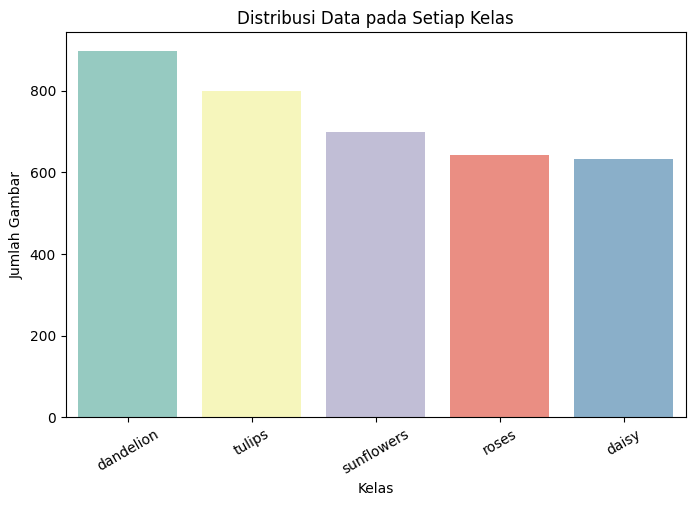

In [50]:
# Visualisasi distribusi label
plt.figure(figsize=(8, 5))
sns.barplot(x=data_count.index, y=data_count.values, palette='Set3')
plt.title('Distribusi Data pada Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=30)
plt.show()

#### **Visualisasi Contoh Gambar dari Setiap Kelas**

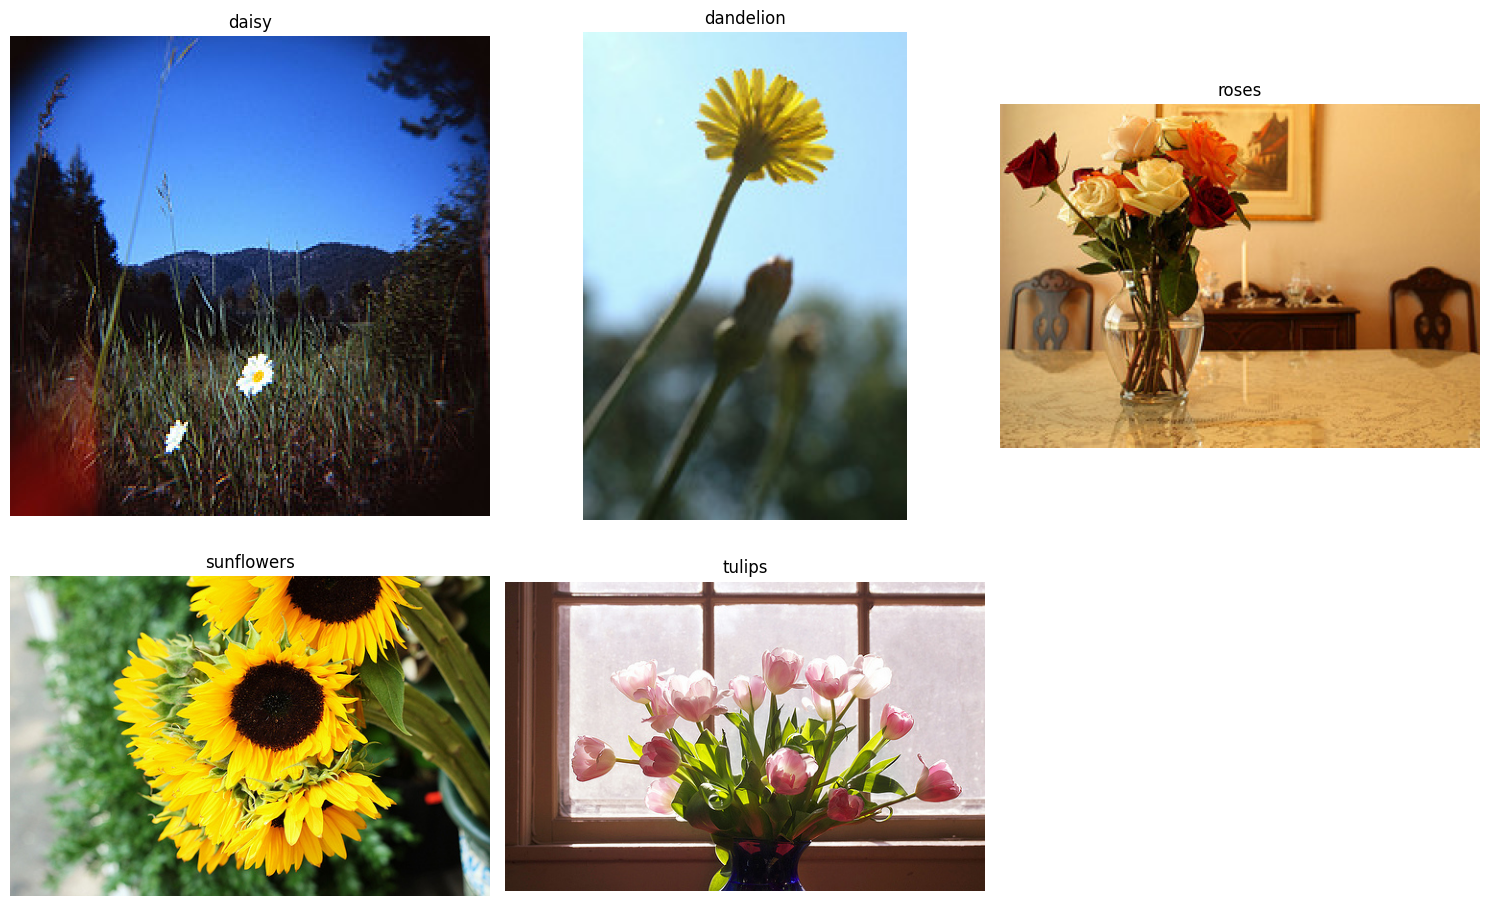

In [51]:
# Visualisasi contoh gambar dari setiap kelas
plt.figure(figsize=(15, 10))
for i, flower in enumerate(classes):
    folder_path = os.path.join(dataset_dir, flower)
    sample_image = os.path.join(folder_path, os.listdir(folder_path)[0])
    image = cv2.imread(sample_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(flower)
    plt.axis('off')
plt.tight_layout()
plt.show()

## **Data Preparation**



#### **Data Preprocessing dan Augmentasi**

In [54]:
# Konfigurasi preprocessing
img_size = (128, 128)
batch_size = 32
dataset_dir = "/content/flower_photos"

# Data preprocessing & augmentasi
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Generator untuk data training
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Generator untuk data validasi
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


#### **Visualisasi Hasil Augmentasi Data**

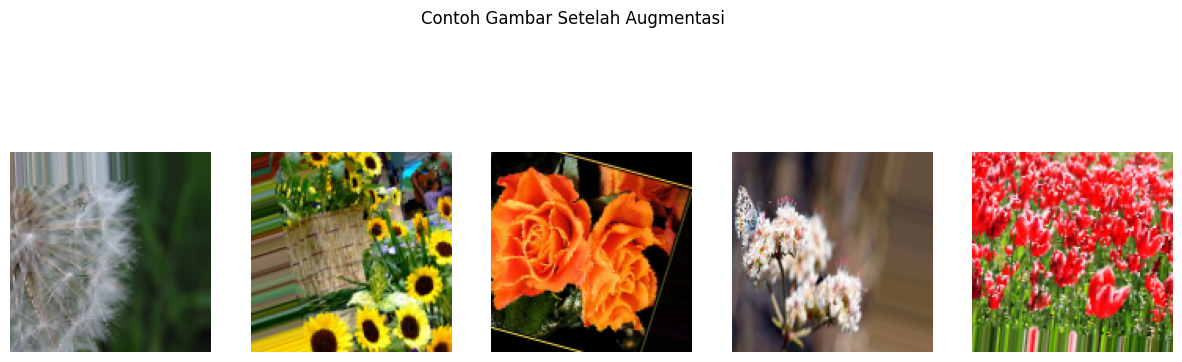

In [55]:
# Mengecek contoh hasil augmentasi
import matplotlib.pyplot as plt

def plot_augmented_images(generator, num_images=5):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.suptitle("Contoh Gambar Setelah Augmentasi")
    plt.show()

# Visualisasi hasil augmentasi data training
plot_augmented_images(train_generator)

## **Modeling**

#### **Model Baseline:**

In [56]:
baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()

# Training
history_baseline = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.3224 - loss: 1.9540 - val_accuracy: 0.4856 - val_loss: 1.2814
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.4894 - loss: 1.2171 - val_accuracy: 0.5663 - val_loss: 1.1469
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5269 - loss: 1.1516 - val_accuracy: 0.5992 - val_loss: 1.1515
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5733 - loss: 1.0660 - val_accuracy: 0.6019 - val_loss: 1.0418
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.6255 - loss: 1.0007 - val_accuracy: 0.6347 - val_loss: 0.9933
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.6267 - loss: 0.9826 - val_accuracy: 0.6129 - val_loss: 0.9752
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.6509 - loss: 0.9103 - val_accuracy: 0.6361 - val_loss: 0.9892
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.6595 - loss: 0.9240 - val_accuracy: 0.6553 - val_loss: 0.

#### **Model Improvement (Transfer Learning):**

In [57]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

# Training
history_transfer = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 743ms/step - accuracy: 0.5388 - loss: 1.2359 - val_accuracy: 0.7948 - val_loss: 0.5900
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 716ms/step - accuracy: 0.7901 - loss: 0.5786 - val_accuracy: 0.8181 - val_loss: 0.5113
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 704ms/step - accuracy: 0.8201 - loss: 0.4863 - val_accuracy: 0.8222 - val_loss: 0.5224
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 721ms/step - accuracy: 0.8384 - loss: 0.4435 - val_accuracy: 0.8249 - val_loss: 0.4933
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 796ms/step - accuracy: 0.8383 - loss: 0.4247 - val_accuracy: 0.8194 - val_loss: 0.5180
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 738ms/step - accuracy: 0.8504 - loss: 0.3870 - val_accuracy: 0.8222 - val_loss: 0.4530
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 703ms/step - accuracy: 0.8623 - loss: 0.3688 - val_accuracy: 0.8263 - val_loss: 0.4724
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 869ms/step - accuracy: 0.8919 - loss: 0.3183 - val_accu

## **Evaluation**

#### **Baseline CNN Evaluation**

In [64]:
# Evaluasi model baseline
baseline_loss, baseline_accuracy = baseline_model.evaluate(val_generator)
print(f"Baseline Model Accuracy: {baseline_accuracy * 100:.2f}%")

# Prediksi data validasi
val_generator.reset()
baseline_predictions = baseline_model.predict(val_generator)
baseline_predicted_classes = np.argmax(baseline_predictions, axis=1)

# Label sebenarnya
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, baseline_predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, baseline_predicted_classes, target_names=class_labels))

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 461ms/step - accuracy: 0.6929 - loss: 0.8498
Baseline Model Accuracy: 65.94%
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step

Confusion Matrix:
[[ 78  25  17   4   2]
 [  5 154   5  14   1]
 [  9   6  78   7  28]
 [  9  20   7  98   5]
 [  5  21  38  10  85]]

Classification Report:
              precision    recall  f1-score   support

       daisy       0.74      0.62      0.67       126
   dandelion       0.68      0.86      0.76       179
       roses       0.54      0.61      0.57       128
  sunflowers       0.74      0.71      0.72       139
      tulips       0.70      0.53      0.61       159

    accuracy                           0.67       731
   macro avg       0.68      0.67      0.67       731
weighted avg       0.68      0.67      0.67       731



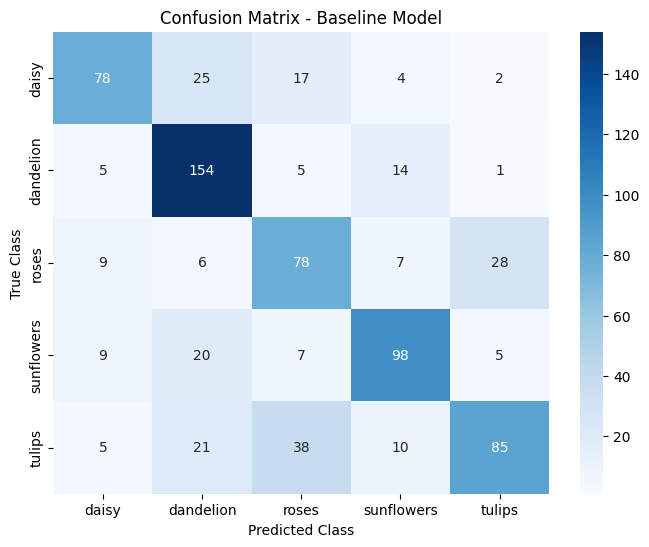

In [65]:
# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Baseline Model")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

#### **Transfer Learning Evaluation**

In [60]:
# Evaluasi model transfer learning
transfer_loss, transfer_accuracy = transfer_model.evaluate(val_generator)
print(f"Transfer Learning Model Accuracy: {transfer_accuracy * 100:.2f}%")

# Prediksi data validasi
val_generator.reset()
transfer_predictions = transfer_model.predict(val_generator)
transfer_predicted_classes = np.argmax(transfer_predictions, axis=1)

# Confusion Matrix
transfer_conf_matrix = confusion_matrix(true_classes, transfer_predicted_classes)
print("\nConfusion Matrix - Transfer Learning:")
print(transfer_conf_matrix)

# Classification Report
print("\nClassification Report - Transfer Learning:")
print(classification_report(true_classes, transfer_predicted_classes, target_names=class_labels))

23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 734ms/step - accuracy: 0.8500 - loss: 0.4639
Transfer Learning Model Accuracy: 83.04%
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 905ms/step

Confusion Matrix - Transfer Learning:
[[111   7   4   1   3]
 [  5 148   2  21   3]
 [  3   0 110   4  11]
 [  4   7   4 118   6]
 [  3   1  20  14 121]]

Classification Report - Transfer Learning:
              precision    recall  f1-score   support

       daisy       0.88      0.88      0.88       126
   dandelion       0.91      0.83      0.87       179
       roses       0.79      0.86      0.82       128
  sunflowers       0.75      0.85      0.79       139
      tulips       0.84      0.76      0.80       159

    accuracy                           0.83       731
   macro avg       0.83      0.84      0.83       731
weighted avg       0.84      0.83      0.83       731



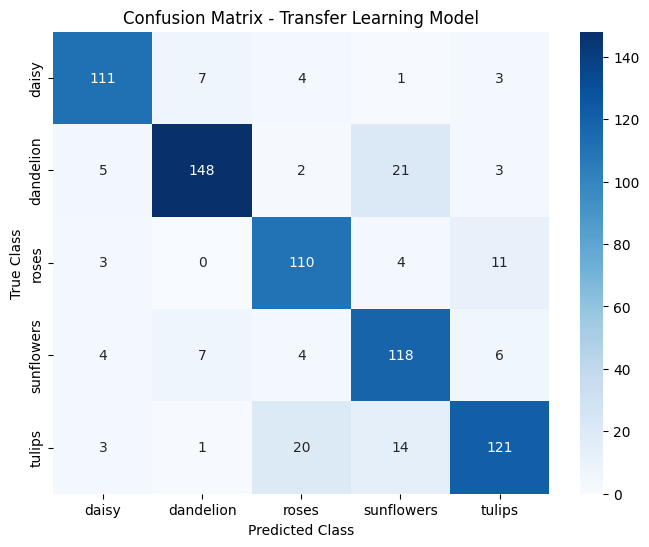

In [77]:
# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(transfer_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Transfer Learning Model")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()